In [9]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline
from datasets import DatasetDict, Dataset
import pandas as pd
import torch
import tensorflow as tf
import numpy as np
import re
import tqdm
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [10]:
# Check that pytorch has access to GPU
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

False
False


In [11]:
# Set global parameters
RANDOM_SEED = 42
TRAIN_IN_PATH = "../data/raw/train.tsv"
TEST_X_IN_PATH = "../data/raw/test_toxic_parallel.txt"
TEST_Y_IN_PATH = "../data/raw/test_toxic_parallel_refs.txt"

In [12]:
# Parameters for toxicity classification
BATCH_SIZE = 32

# Setting the DEVICE to CUDA if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Data preprocessing

# Functions

In [19]:
# Load tokenizer and model for toxicity classification
tokenizer_toxicity = RobertaTokenizer.from_pretrained("SkolkovoInstitute/roberta_toxicity_classifier")
model_toxicity = RobertaForSequenceClassification.from_pretrained(
    "SkolkovoInstitute/roberta_toxicity_classifier"
)

def classify_toxicity_binary(
    data,
    tokenizer=tokenizer_toxicity,
    model=model_toxicity,
    batch_size=BATCH_SIZE,
    include_tqdm=False,
    output_type="numpy",
    flatten_output=True,
):
    """
    Classifies text as toxic or neutral.

    Args:
        data (list): The list of text to classify.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use.
        model (transformers.PreTrainedModel): The model to use.
        batch_size (int): The batch size to use.
        include_tqdm (bool): Whether to include tqdm progress bar output.
        output_type (str): The type of output to return. 'numpy', 'list', 'int'

    Returns:
        results of the classification (nparray, list or int) where 0 is neutral and 1 is toxic.
    """
    if isinstance(data, (np.ndarray, str)):
        data = data.tolist() if isinstance(data, np.ndarray) else [data]

    model = model.to(DEVICE)

    results = np.empty(len(data), dtype=int) if output_type == "numpy" else []

    for i in tqdm.tqdm(range(0, len(data), batch_size), disable=not include_tqdm):
        batch = tokenizer(data[i : i + batch_size], return_tensors="pt", padding=True).to(DEVICE)
        with torch.no_grad():
            result = model(**batch)["logits"].argmax(1).data
            result = result.cpu()
        if output_type == "numpy":
            results[i : i + batch_size] = result
        else:
            results.extend(result.tolist())

    if flatten_output and len(results) == 1:
        return results[0]

    return results


def calc_toxicity_cols(df, toxic_col="en_toxic_comment", neutral_col="en_neutral_comment"):
    """
    Classifies comments as toxic or neutral

    Args:
        df (pandas.DataFrame): The dataframe with two columns of comments to classify.

    Returns:
        pandas.DataFrame: The dataframe with two new columns of toxicity classifications.
    """

    df_toxiclabels = df.copy()

    df_toxiclabels["en_toxic_label"] = df_toxiclabels[toxic_col].apply(
        lambda x: classify_toxicity_binary(x, flatten_output=True)
    )
    df_toxiclabels["en_neutral_label"] = df_toxiclabels[neutral_col].apply(
        lambda x: classify_toxicity_binary(x, flatten_output=True)
    )

    return df_toxiclabels


def calc_toxicity_metrics(df):
    """Calculates the number of comments classified as toxic or neutral"""
    length = len(df)
    toxic_correct = df["en_toxic_label"].sum()
    toxic_incorrect = length - toxic_correct
    neutral_incorrect = df["en_neutral_label"].sum()
    neutral_correct = length - neutral_incorrect

    print(f"Total number of comments: {length}")
    print(f"Toxic comments classified as toxic: {toxic_correct}")
    print(f"Toxic comments classified as neutral: {toxic_incorrect}")
    print(f"Neutral comments classified as neutral: {neutral_correct}")
    print(f"Neutral comments classified as toxic: {neutral_incorrect}")

    # return length, toxic_correct, toxic_incorrect, neutral_correct, neutral_incorrect


def get_unique_rows(df):
    """
    Returns a DataFrame with unique rows based on en_toxic_comment

    Args:
        df (pandas.DataFrame): The DataFrame to filter.
                               Should contain a column named en_toxic_comment, and a column named en_neutral_label.

    Returns:
        pandas.DataFrame: The filtered DataFrame.
    """
    # Only keep the first row for each unique en_toxic_comment, selecting the row with the lowest en_neutral_label (ideally 0)
    df_unique = df.sort_values(by="en_neutral_label").drop_duplicates(subset="en_toxic_comment", keep="first")

    # Reset index of the df_unique DataFrame
    df_unique.reset_index(drop=True, inplace=True)

    return df_unique


def clean_text(text):
    """
    Clean the text

    Args:
        text (str): The text to clean.

    Returns:
        str: The cleaned text.
    """
    # Convert first character to uppercase
    text = text[0].upper() + text[1:]

    # # Remove newline characters
    text = re.sub(r"\n", " ", text)

    # Remove white space after $
    text = re.sub(r"([$])\s+", r"\1", text)

    # Remove white space trailing punctuation end of sentence
    text = re.sub(r"\s+([.,!?%])", r"\1", text)

    # Remove white space before contractions (e.g., "I 'm John" becomes "I'm John")
    text = re.sub(r"\s\'(s|t|ve|ll|d|re|m)\b", r"'\1", text)

    # Remove white space around text within double quotes
    text = re.sub(r'"(\s*.*?\s*)"', r'"\1"', text)

    # Remove white space around text within single quotes
    text = re.sub(r"'(\s*.*?\s*)'", r"'\1'", text)

    # Remove white space around text within parentheses
    text = re.sub(r"\((\s*.*?\s*)\)", r"(\1)", text)

    # Remove white space around text within square brackets
    text = re.sub(r"\[(\s*.*?\s*)\]", r"[\1]", text)

    # Remove white space around text within curly brackets
    text = re.sub(r"\{(\s*.*?\s*)\}", r"{\1}", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text


def clean_dataset(df):
    """
    Clean the dataset by converting the text to lowercase, removing extra whitespace,
    and removing non-alphanumeric characters except for some punctuation.

    Args:
        df (pandas.DataFrame): The DataFrame to clean. Should contain a column named en_toxic_comment.

    Returns:
        pandas.DataFrame: The cleaned DataFrame.
    """
    # Create a copy of the dataframe to avoid modifying the original dataframe
    df_clean = df.copy()

    # Clean the text in the en_toxic_comment column
    df_clean["en_toxic_comment"] = df_clean["en_toxic_comment"].apply(lambda x: clean_text(x))

    # Clean the text in the en_neutral_comment column
    df_clean["en_neutral_comment"] = df_clean["en_neutral_comment"].apply(lambda x: clean_text(x))

    return df_clean


def prepare_and_save_data(df, x_col_name, y_col_name, random_seed, x_output_path, y_output_path):
    """
    Shuffle and split the dataframe into X and y based on the given column names,
    and then save them to CSV files.

    Parameters:
    - df: The dataframe to be processed
    - x_col_name: The name of the column containing the features
    - y_col_name: The name of the column containing the labels
    - random_seed: The random seed for shuffling
    - x_output_path: The path to save the features CSV
    - y_output_path: The path to save the labels CSV
    """

    # Print the number of rows in the dataframe
    print(f"Number of rows in the dataframe: {len(df)}")

    # Shuffle the data
    df_shuffled = df.sample(frac=1, random_state=random_seed)

    # Split the data into X and y
    X = df_shuffled[x_col_name].tolist()
    y = df_shuffled[y_col_name].tolist()

    # Save as CSV files
    pd.DataFrame(X).to_csv(x_output_path, index=False, header=False)
    pd.DataFrame(y).to_csv(y_output_path, index=False, header=False)

def create_raw_dataset(df_train_clean, df_val_clean, df_test_clean, source_col='en_toxic_comment', target_col='en_neutral_comment'):
    """
    Creates a DatasetDict from the given DataFrames

    Args:
        df_train_clean (pandas.DataFrame): The training DataFrame.
        df_val_clean (pandas.DataFrame): The validation DataFrame.
        df_test_clean (pandas.DataFrame): The test DataFrame.
        source_col (str): The name of the column containing the source text.
        target_col (str): The name of the column containing the target text.

    Returns:
        datasets.DatasetDict: The DatasetDict containing the train, validation and test Datasets.
    """

    # Shuffle all the DataFrames
    df_train_clean = df_train_clean.sample(frac=1, random_state=RANDOM_SEED)
    df_val_clean = df_val_clean.sample(frac=1, random_state=RANDOM_SEED)
    df_test_clean = df_test_clean.sample(frac=1, random_state=RANDOM_SEED)
    
    # Create dictionaries from your data
    train_dict = {'source': df_train_clean[source_col], 'target': df_train_clean[target_col]}
    val_dict = {'source': df_val_clean[source_col], 'target': df_val_clean[target_col]}
    test_dict = {'source': df_test_clean[source_col], 'target': df_test_clean[target_col]}

    # Convert dictionaries to Dataset objects
    train_dataset = Dataset.from_dict(train_dict)
    val_dataset = Dataset.from_dict(val_dict)
    test_dataset = Dataset.from_dict(test_dict)

    # Now create a DatasetDict
    raw_dataset = DatasetDict({
        'train': train_dataset,
        'validation': val_dataset,
        'test': test_dataset    })
    
    return raw_dataset

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Experiments to test which toxicity classifier to use

In [5]:
# Load training data
df_train = pd.read_csv("../data/raw/train.tsv", sep="\t")

# Randomly sample 500 rows from the training data
df_train_sample = df_train.sample(n=500, random_state=RANDOM_SEED)

# Construct two lists, one for each column
toxic_comments = df_train_sample["en_toxic_comment"].tolist()
neutral_comments = df_train_sample["en_neutral_comment"].tolist()

### Experiment A: Roberta toxicity classifier

In [6]:
# Classify the comments as toxic or neutral using roberta_toxicity_classifier
pipe_roberta = pipeline("text-classification", model="s-nlp/roberta_toxicity_classifier")
toxic_labels_roberta = pipe_roberta(toxic_comments)
neutral_labels_roberta = pipe_roberta(neutral_comments)

# Calculate number of comments classified as toxic or neutral
length = len(df_train_sample)
toxic_correct = sum([1 for label in toxic_labels_roberta if label["label"] == "toxic"])
toxic_incorrect = length - toxic_correct
neutral_incorrect = sum([1 for label in neutral_labels_roberta if label["label"] == "toxic"])
neutral_correct = length - neutral_incorrect

# Print results
print(f"Total number of comments: {length}")
print(f"Toxic comments classified as toxic: {toxic_correct}")
print(f"Toxic comments classified as neutral: {toxic_incorrect}")
print(f"Neutral comments classified as neutral: {neutral_correct}")
print(f"Neutral comments classified as toxic: {neutral_incorrect}")

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total number of comments: 500
Toxic comments classified as toxic: 500
Toxic comments classified as neutral: 0
Neutral comments classified as neutral: 475
Neutral comments classified as toxic: 25


### Experiment B: Unitary toxicity classifier

In [7]:
# Classify the comments as toxic or neutral using toxicbert
pipe_toxicbert = pipeline("text-classification", model="unitary/toxic-bert")
toxic_labels_toxicbert = pipe_toxicbert(toxic_comments)
neutral_labels_toxicbert = pipe_toxicbert(neutral_comments)

# Calculate number of comments classified as toxic or neutral
length = len(df_train_sample)
toxic_correct_toxicbert = sum([1 for label in toxic_labels_toxicbert if label["score"] > 0.5])
toxic_incorrect_toxicbert = length - toxic_correct_toxicbert
neutral_incorrect_toxicbert = sum([1 for label in neutral_labels_toxicbert if label["score"] > 0.5])
neutral_correct_toxicbert = length - neutral_incorrect_toxicbert

# Print results
print(f"Total number of comments: {length}")
print(f"Toxic comments classified as toxic: {toxic_correct_toxicbert}")
print(f"Toxic comments classified as neutral: {toxic_incorrect_toxicbert}")
print(f"Neutral comments classified as neutral: {neutral_correct_toxicbert}")
print(f"Neutral comments classified as toxic: {neutral_incorrect_toxicbert}")

Total number of comments: 500
Toxic comments classified as toxic: 475
Toxic comments classified as neutral: 25
Neutral comments classified as neutral: 474
Neutral comments classified as toxic: 26


The code below shows that 0.5 is the best treshold to separate toxic and neutral

/var/folders/v5/yt7ng4cx6bg_z_j227f15vsw0000gn/T/ipykernel_86385/2812041744.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(toxic_scores, shade=True)
/var/folders/v5/yt7ng4cx6bg_z_j227f15vsw0000gn/T/ipykernel_86385/2812041744.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neutral_scores, shade=True)


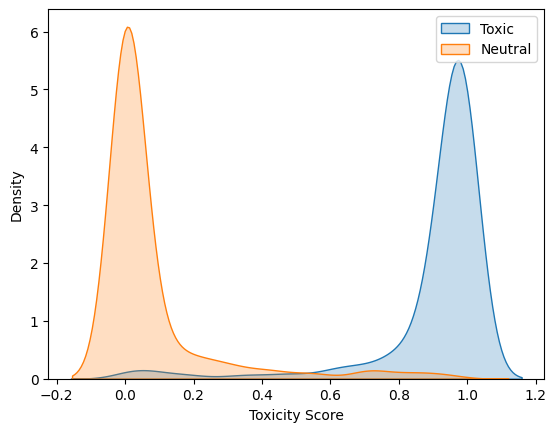

In [8]:
def plot_toxicbert_scores(toxic_labels_toxicbert, neutral_labels_toxicbert):
    """
    Plots density plots of toxic_scores and neutral_scores from toxicbert outputs
    """
    # Create a list containing all the 'score' values for toxic comments
    toxic_scores = []
    for label in toxic_labels_toxicbert:
        toxic_scores.append(label["score"])

    # Create a list containing all the 'score' values for neutral comments
    neutral_scores = []
    for label in neutral_labels_toxicbert:
        neutral_scores.append(label["score"])

    # Plot density plots of toxic_scores and neutral_scores
    sns.kdeplot(toxic_scores, shade=True)
    sns.kdeplot(neutral_scores, shade=True)
    plt.legend(["Toxic", "Neutral"])
    plt.xlabel("Toxicity Score")
    plt.ylabel("Density")


plot_toxicbert_scores(toxic_labels_toxicbert, neutral_labels_toxicbert)

The above shows that the RobertA toxicity classifier performs better than the unitary toxicity classifier

# Training Data

### Data Acquisition

Note that the original training data is found is the huggingface data: https://huggingface.co/datasets/s-nlp/paradetox

In [7]:
df_train = pd.read_csv(TRAIN_IN_PATH, sep="\t")
df_train

,en_toxic_comment,en_neutral_comment
0,he had steel balls too !,he was brave too!
1,"dude should have been taken to api , he would ...",It would have been good if he went to api. He ...
2,"im not gonna sell the fucking picture , i just...","I'm not gonna sell the picture, i just want to..."
3,the garbage that is being created by cnn and o...,the news that is being created by cnn and othe...
4,the reason they dont exist is because neither ...,The reason they don't exist is because neither...
...,...,...
19739,when they do shit like this .,when they do stuff like this
19740,"but if saying "" fuck that group "" is much more...","but if saying"" that group is bad"" is much more..."
19741,"it hurts how judgemental assholes view them , ...",It hurts how judgemental that people view them...
19742,shit we probably literally blow that up in a w...,We probably litteralky blow that up in a week.


### Check distribution of toxicity classification in columns

In [8]:
# Add new columns to the dataframe based on toxicity classifier
df_train_toxiclabels = calc_toxicity_cols(df_train)

In [9]:
# Save the dataframe as a pickle file
df_train_toxiclabels.to_pickle("../data/interim/df_train_1_toxiclabels.pkl")

In [10]:
# Calculate number of comments classified as toxic or neutral
calc_toxicity_metrics(df_train_toxiclabels)

Total number of comments: 19744
Toxic comments classified as toxic: 19741
Toxic comments classified as neutral: 3
Neutral comments classified as neutral: 18881
Neutral comments classified as toxic: 863


In [11]:
# Print rows where toxic_label is 0 (incorrectly classified)
print("Toxic comments classified as neutral:")
for sentence in df_train_toxiclabels[df_train_toxiclabels["en_toxic_label"] == 0]["en_toxic_comment"].head(
    20
):
    print(sentence)

# Print rows where en_neutral_label is 1 (incorrectly classified)
print()
print("Neutral comments classified as toxic:")
for sentence in df_train_toxiclabels[df_train_toxiclabels["en_neutral_label"] == 1][
    "en_neutral_comment"
].head(20):
    print(sentence)

Toxic comments classified as neutral:
but some shit happened last night kinda hurt but god will heal me < 57
#ERROR!
#ERROR!

Neutral comments classified as toxic:
If any of the cry babies who dont respect democracy come , it will be the bad drain.
immoral people who should be driven out of office asap .
Oh , one more thing, when it comes to prehistoric life, you guys are not so smart.
This is a free country that protects amendments rights from communists like you.
Your remark is ignorant.
You don't have to hurt their families further by commenting on ignorant decisions.
the free world doesnt need your ignorance .
damn , he was back home and should have stayed there .
talk about an ignorant comment
Sadly, the gay community, and it's companions, refuses to accept the evidence.
as useless as a human rights and social justice lawyer masquerading as our minister of environment and climate change .
were tired of your lies
a shining beacon of ignorance .
Gay, Muslim,no anglophone,white males

To avoid bias in evaluation, I opt not to remove false positives and false negatives based on the pre-trained roberta toxicity classifier. However we will remove rows with #ERROR! in the en_toxic_comment field

In [12]:
df_train_toxiclabels[df_train_toxiclabels["en_toxic_label"] == 0]

,en_toxic_comment,en_neutral_comment,en_toxic_label,en_neutral_label
4228,but some shit happened last night kinda hurt b...,but some happened last night hurt but God will...,0,0
10046,#ERROR!,that black person knows he is going in to trouble,0,1
10383,#ERROR!,#ERROR!,0,0


In [13]:
# Filter out rows where en_toxic_comment is "#ERROR!"
df_train_filtered = df_train_toxiclabels[df_train_toxiclabels["en_toxic_comment"] != "#ERROR!"]
print(f"Number of rows before filtering for error in toxic comment: {len(df_train_toxiclabels)}")
print(f"Number of rows after filtering for error in toxic comment: {len(df_train_filtered)}")

# Save the dataframe as a pickle file
df_train_filtered.to_pickle("../data/interim/df_train_2_filtered.pkl")

Number of rows before filtering for error in toxic comment: 19744
Number of rows after filtering for error in toxic comment: 19742


### Remove duplicate rows

In the ParaDetox paper, BART does not perform better on multiple detoxifications per sentence than if only one detoxification is used. So, we will limit to just one row per toxic comment

In [14]:
df_train_filtered = pd.read_pickle("../data/interim/df_train_2_filtered.pkl")

In [15]:
print(f"Number of rows before removing duplicates: {len(df_train_filtered)}")
df_train_unique = get_unique_rows(df_train_filtered)
print(f"Number of rows after removing duplicates: {len(df_train_unique)}")

Number of rows before removing duplicates: 19742
Number of rows after removing duplicates: 11926


In [16]:
calc_toxicity_metrics(df_train_unique)

Total number of comments: 11926
Toxic comments classified as toxic: 11925
Toxic comments classified as neutral: 1
Neutral comments classified as neutral: 11357
Neutral comments classified as toxic: 569


In [17]:
df_train_unique.to_pickle("../data/interim/df_train_3_unique.pkl")

### Clean text

Transformer-based models are generally robust to text inconsistencies and aspects such as case sensitivity, punctuation, contractions, and newline contractions may convey important information. However to ensure consistency between training and test data we apply basic cleaning. This is also to ensure consistency between the source and target data:

In [18]:
df_train_unique = pd.read_pickle("../data/interim/df_train_3_unique.pkl")
df_train_clean = clean_dataset(df_train_unique)
df_train_clean.to_pickle("../data/interim/df_train_4_clean.pkl")

In [19]:
for i in range(10):
    print(df_train_unique["en_toxic_comment"][i])
    print(df_train_clean["en_toxic_comment"][i])
    print()
    print(df_train_unique["en_neutral_comment"][i])
    print(df_train_clean["en_neutral_comment"][i])

he had steel balls too !
He had steel balls too!

he was brave too!
He was brave too!
this bigoted control freak shit is getting tiresome .
This bigoted control freak shit is getting tiresome.

This bigoted control is getting bored.
This bigoted control is getting bored.
well when you treat your employees like shit and you don 't pay them well .
Well when you treat your employees like shit and you don't pay them well.

When you do not treat and pay your employees well.
When you do not treat and pay your employees well.
netanyahu might be a bigger ass than cheney
Netanyahu might be a bigger ass than cheney

Netanyahu might be a bigger bad person than Cheney.
Netanyahu might be a bigger bad person than Cheney.
i doubt people in china , india , russia etc gave two fucks about him edit blimey , lol
I doubt people in china, india, russia etc gave two fucks about him edit blimey, lol

doubt people in china , india , russia etc gave a second thought about him edit blimey
Doubt people in china

### Split data to X and y, and train and val

In [15]:
df_train_clean = pd.read_pickle("../data/interim/df_train_4_clean.pkl")

# Split df_train_clean into train and validation sets
df_train_clean, df_val_clean = train_test_split(df_train_clean, test_size=0.1, random_state=RANDOM_SEED)

Number of rows in the dataframe: 10733
Number of rows in the dataframe: 1193


# Test data

### Data Acquisition

In [21]:
def load_test(toxic_comments_path, neutral_comments_path):
    """Loads the test data from the given paths and returns a DataFrame with two columns of comments"""
    with open(toxic_comments_path, "r") as file:
        toxic_comments = file.readlines()

    with open(neutral_comments_path, "r") as file:
        neutral_comments = file.readlines()

    df = pd.DataFrame({"en_toxic_comment": toxic_comments, "en_neutral_comment": neutral_comments})

    # Remove newline character at the end of each comment (as this is not part of the comment)
    df["en_toxic_comment"] = df["en_toxic_comment"].apply(lambda x: x[:-1])
    df["en_neutral_comment"] = df["en_neutral_comment"].apply(lambda x: x[:-1])

    return df

df_test = load_test(toxic_comments_path=TEST_X_IN_PATH, neutral_comments_path=TEST_Y_IN_PATH)
df_test.head()

,en_toxic_comment,en_neutral_comment
0,. or the loud ass one - thousand ton beast roa...,or the loud one - thousand ton beast roaring ...
1,"mandated and "" right fucking now "" would be ...","Mandated' and right now"" would be good."
2,* neither * of my coworkers gave a shit when i...,Neither of my co-workers cared when it came to...
3,"* well shit , cunt shot himself .","*well, he shot himself."
4,&gt i wouldn 't care how ignorant you are in y...,i wouldn 't care how ignorant you are in you w...


In [22]:
# Check that the rows map to each other
for i in range(10):
    print(df_test["en_toxic_comment"][i])
    print(df_test["en_neutral_comment"][i])
    print()

. or the loud ass one - thousand ton beast roaring towards you howling its horn .
or the loud  one - thousand ton beast roaring towards you howling its horn .

 mandated  and " right fucking now " would be good .
Mandated' and right now" would be good.

* neither * of my coworkers gave a shit when it came time to ditch mitch . ugh .
Neither of my co-workers cared when it came to ditching Mitch.

* well shit , cunt shot himself .
*well, he shot himself.

&gt i wouldn 't care how ignorant you are in you weren 't pretending to know shit .
i wouldn 't care how ignorant you are in you weren 't pretending to know things

&gt today was one of the most fucked up days of my life .
& today was one of the worst days of my life

<number> , people will freak the fuck out .
<number> people will freak out

3 . you don 't fuck with a mommas boy
you don 't joke with a mommas boy

6. are you fucking insane ?
Are you insane?

abortion is not a fundamental right it is a proceedure , nothing more idiot
Abo

### Check distribution of toxicity classification

In [23]:
# Add new columns to the dataframe based on toxicity classifier
df_test_toxiclabels = calc_toxicity_cols(df_test)
df_test_toxiclabels.to_pickle("../data/interim/df_test_1_toxiclabels.pkl")

In [24]:
# Calculate number of comments classified as toxic or neutral
calc_toxicity_metrics(df_test_toxiclabels)

Total number of comments: 671
Toxic comments classified as toxic: 665
Toxic comments classified as neutral: 6
Neutral comments classified as neutral: 641
Neutral comments classified as toxic: 30


In [25]:
# Print rows where toxic_label is 0 (incorrectly classified)
print("Toxic comments classified as neutral:")
for sentence in df_test_toxiclabels[df_test_toxiclabels["en_toxic_label"] == 0]["en_toxic_comment"].head(10):
    print(sentence)

print()
# Print rows where en_neutral_label is 1 (incorrectly classified)
print("Neutral comments classified as toxic:")
for sentence in df_test_toxiclabels[df_test_toxiclabels["en_neutral_label"] == 1]["en_neutral_comment"].head(
    10
):
    print(sentence)

Toxic comments classified as neutral:
<number> , people will freak the fuck out .
i could understand how many people would shit their pants seeing a title like this
i don 't think it 's fucked up since it 's not like she had to accept .
i mean it 's killed a shit ton of people and now they 're gonna give it an established base of operations ?
this is scaring the shit out of me .
we rely on our government to protect us the military yet conservatives aren 't bitching about that .

Neutral comments classified as toxic:
i wouldn 't care how ignorant you are in you weren 't pretending to know things
Are you insane?
Another person who is racist.
all you trump supporters are seriously messed up .
amy , your lack of understanding is showing again
Are they liars or unaware?
Bloated nonsense that comes out of these other
All governments are corrupt
DIGIT are you suggesting that should be enough to keep black people satisfied?
barbarian gooks got a lot of nerve to mess with us.


### Remove duplicate rows

This is less applicable due to the underlying structure, but let's quickly check if there are duplicate rows

In [26]:
# Count the number of rows where en_toxic_comment is not unique
print(
    f"Number of rows where en_toxic_comment is not unique: {len(df_test_toxiclabels[df_test_toxiclabels.duplicated(subset=['en_toxic_comment'])])}"
)

# Count the number of rows where en_neutral_comment is not unique
print(
    f"Number of rows where en_neutral_comment is not unique: {len(df_test_toxiclabels[df_test_toxiclabels.duplicated(subset=['en_neutral_comment'])])}"
)

Number of rows where en_toxic_comment is not unique: 0
Number of rows where en_neutral_comment is not unique: 0


### Clean text

In [27]:
df_test_toxiclabels = pd.read_pickle("../data/interim/df_test_1_toxiclabels.pkl")
df_test_clean = clean_dataset(df_test_toxiclabels)
df_test_clean.to_pickle("../data/interim/df_test_2_clean.pkl")

In [28]:
for i in range(10):
    print(df_test_toxiclabels["en_toxic_comment"][i])
    print(df_test_clean["en_toxic_comment"][i])
    print(df_test_toxiclabels["en_neutral_comment"][i])
    print(df_test_clean["en_neutral_comment"][i])
    print()

. or the loud ass one - thousand ton beast roaring towards you howling its horn .
. or the loud ass one - thousand ton beast roaring towards you howling its horn.
or the loud  one - thousand ton beast roaring towards you howling its horn .
Or the loud one - thousand ton beast roaring towards you howling its horn.

 mandated  and " right fucking now " would be good .
mandated and " right fucking now " would be good.
Mandated' and right now" would be good.
Mandated' and right now" would be good.

* neither * of my coworkers gave a shit when it came time to ditch mitch . ugh .
* neither * of my coworkers gave a shit when it came time to ditch mitch. ugh.
Neither of my co-workers cared when it came to ditching Mitch.
Neither of my co-workers cared when it came to ditching Mitch.

* well shit , cunt shot himself .
* well shit, cunt shot himself.
*well, he shot himself.
*well, he shot himself.

&gt i wouldn 't care how ignorant you are in you weren 't pretending to know shit .
&gt i wouldn't

# Combine to DatasetDict

In [21]:
raw_dataset = create_raw_dataset(
    df_train_clean,
    df_val_clean,
    df_test_clean,
    source_col="en_toxic_comment",
    target_col="en_neutral_comment"
)
raw_dataset.save_to_disk("../data/processed/raw_datasets")

Saving the dataset (0/1 shards):   0%|          | 0/10733 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1193 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/671 [00:00<?, ? examples/s]